In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Cancer data
stage_1_samples = pd.read_csv('../data/cancer/stage_1_prostate_cancer_samples.csv')
stage_1_samples.head(2)

,Sample_ID,hsa-miR-28-3p,hsa-miR-27a-5p,hsa-miR-518b,hsa-miR-520b,hsa-miR-498,hsa-miR-512-3p,hsa-miR-491-5p,hsa-miR-490-3p,hsa-miR-452-5p,...,hsa-miR-6881-5p,hsa-miR-6880-3p,hsa-miR-6873-5p,hsa-miR-6872-3p,hsa-miR-6865-5p,hsa-miR-6864-3p,Sex,Age,Stage,Disease
0,PR0277,2.760943,2.400863,4.151937,0.484683,5.468257,-0.520376,5.732963,5.127806,1.331229,...,-0.520376,6.436273,-0.520376,6.122591,4.084076,1.802269,Sex: Male,age: 63,Stage: 1,disease state: prostate cancer
1,PR0279,6.440539,6.488169,6.982107,6.693205,7.526893,5.907250,6.847291,6.702204,6.725169,...,3.697720,6.420387,0.622814,6.653990,6.248935,0.622814,Sex: Male,age: 73,Stage: 1,disease state: prostate cancer


In [3]:
stage_2_samples = pd.read_csv('../data/cancer/stage_2_prostate_cancer_samples.csv')
stage_2_samples.head(2)

,Sample_ID,hsa-miR-28-3p,hsa-miR-27a-5p,hsa-miR-518b,hsa-miR-520b,hsa-miR-498,hsa-miR-512-3p,hsa-miR-491-5p,hsa-miR-490-3p,hsa-miR-452-5p,...,hsa-miR-6881-5p,hsa-miR-6880-3p,hsa-miR-6873-5p,hsa-miR-6872-3p,hsa-miR-6865-5p,hsa-miR-6864-3p,Sex,Age,Stage,Disease
0,PR0002,1.055860,1.055860,3.059547,3.591703,7.240287,1.055860,6.445358,4.847365,4.650662,...,1.055860,6.326661,1.055860,6.250896,7.053440,1.055860,Sex: Male,age: 76,Stage: 2,disease state: prostate cancer
1,PR0003,0.602401,0.602401,4.087566,0.602401,6.448268,0.602401,3.159369,0.602401,0.602401,...,6.137515,6.703970,5.262093,7.028362,7.167895,4.971255,Sex: Male,age: 63,Stage: 2,disease state: prostate cancer


In [4]:
# Combine stage 1 and stage 2 samples
combined_dataset = pd.concat([stage_1_samples, stage_2_samples], ignore_index=True)

# Verify the Stage column exists and print unique values
print("Unique values in Stage column:", combined_dataset['Stage'].unique())

# Strip the "Stage: " prefix from the Stage column and then label the samples
combined_dataset['Stage'] = combined_dataset['Stage'].str.strip()

# Label the samples (0 for stage 1, 1 for stage 2)
combined_dataset['ID_REF'] = np.where(combined_dataset['Stage'] == 'Stage: 1', 0, 1)
combined_dataset['ID_REF'] = np.where(combined_dataset['Stage'] == 'Stage: 2', 1, combined_dataset['ID_REF'])

# Print class distribution to ensure both classes are present
print("Class distribution in ID_REF column:")
print(combined_dataset['ID_REF'].value_counts()) 

Unique values in Stage column: ['Stage: 1' 'Stage: 2']
Class distribution in ID_REF column:
ID_REF
1    395
0    173
Name: count, dtype: int64


In [5]:
def process_data(data, under_sample_factor=None, over_sample_factor=None):
    # Drop metadata columns
    columns_to_drop = ['Sample_ID', 'Sex', 'Age', 'Stage', 'Disease']
    data = data.drop(columns=columns_to_drop, axis=1)
    
    x = np.array(data.drop(["ID_REF"], axis=1)).astype('float')
    y = np.array(data["ID_REF"]).astype('int')
    feature_names = data.columns[1:]

    if under_sample_factor is not None and isinstance(under_sample_factor, float) and 0 < under_sample_factor <= 1:
        under_sampler = RandomUnderSampler(sampling_strategy=under_sample_factor)
        x, y = under_sampler.fit_resample(x, y)

    if over_sample_factor is not None and isinstance(over_sample_factor, float) and 0 < over_sample_factor <= 1:
        over_sampler = RandomOverSampler(sampling_strategy=over_sample_factor)
        x, y = over_sampler.fit_resample(x, y)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

    # Normalization
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test, feature_names

In [6]:
# Support Vector Machine model
def support_vector_machine(x_train, y_train, feature_num):
    pipe = Pipeline([('skb', SelectKBest(f_classif, k=feature_num)), ('estimator', SVC())])

    pipe_parameters = {'skb__k': [feature_num],
                       'estimator__C': [0.25, 0.5, 0.75, 1],
                       'estimator__kernel': ['linear']}

    svm_grid_search = GridSearchCV(pipe, pipe_parameters, scoring='accuracy', cv=StratifiedKFold(10), n_jobs=-1)
    svm_grid_search.fit(x_train, y_train)

    return svm_grid_search

In [7]:
# Get SVM metrics
def get_svm_metrics(svm_grid_search, x_test, y_test):
    best_accuracy = svm_grid_search.best_score_
    best_parameters = svm_grid_search.best_params_
    print("Training Accuracy:", best_accuracy)
    print("Best Parameters:", best_parameters)

    y_pred = svm_grid_search.predict(x_test)
    matrix = confusion_matrix(y_test, y_pred)
    print("Testing Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(matrix)

In [8]:
# Get top SVM features
def get_top_svm_features(svm_grid_search, feature_names, top_feature_num):
    coef_list = svm_grid_search.best_estimator_.named_steps['estimator'].coef_[0]
    features = svm_grid_search.best_estimator_.named_steps['skb'].get_support()
    selected_features_list = feature_names[features].tolist()

    coef_list, selected_features_list = zip(*sorted(zip(abs(coef_list), selected_features_list), reverse=True))
    coef_list, selected_features_list = list(coef_list), list(selected_features_list)

    return coef_list[:top_feature_num], selected_features_list[:top_feature_num]

In [9]:
# Random Forest model
def random_forest(x_train, y_train, feature_num):
    pipe = Pipeline([('skb', SelectKBest(f_classif, k=feature_num)), ('estimator', RandomForestClassifier(random_state=0))])

    pipe_parameters = {'skb__k': [feature_num],
                       'estimator__n_estimators': [100, 500],
                       'estimator__max_features': ['sqrt', 'log2'],
                       'estimator__criterion': ['gini', 'entropy']}

    rf_grid_search = GridSearchCV(pipe, pipe_parameters, scoring='accuracy', cv=StratifiedKFold(10), n_jobs=-1)
    rf_grid_search.fit(x_train, y_train)

    return rf_grid_search

In [10]:
# Get Random Forest metrics
def get_rf_metrics(rf_grid_search, x_test, y_test):
    best_accuracy = rf_grid_search.best_score_
    best_parameters = rf_grid_search.best_params_
    print("Training Accuracy:", best_accuracy)
    print("Best Parameters:", best_parameters)

    y_pred = rf_grid_search.predict(x_test)
    matrix = confusion_matrix(y_test, y_pred)
    print("Testing Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(matrix)

In [11]:
# Get top Random Forest features
def get_top_rf_features(rf_grid_search, feature_names, top_feature_num):
    importance_list = rf_grid_search.best_estimator_.named_steps['estimator'].feature_importances_
    features = rf_grid_search.best_estimator_.named_steps['skb'].get_support()
    selected_features_list = feature_names[features].tolist()

    importance_list, selected_features_list = zip(*sorted(zip(importance_list, selected_features_list), reverse=True))
    importance_list, selected_features_list = list(importance_list), list(selected_features_list)

    return importance_list[:top_feature_num], selected_features_list[:top_feature_num]

In [12]:
# Gradient Boosting model
def gradient_boosting(x_train, y_train, feature_num):
    pipe = Pipeline([('skb', SelectKBest(f_classif, k=feature_num)), ('estimator', GradientBoostingClassifier())])

    pipe_parameters = {'skb__k': [feature_num],
                       'estimator__learning_rate': [0.5, 1],
                       'estimator__n_estimators': [50]}

    gb_grid_search = GridSearchCV(pipe, pipe_parameters, scoring='accuracy', cv=StratifiedKFold(10), n_jobs=-1)
    gb_grid_search.fit(x_train, y_train)

    return gb_grid_search

In [13]:
# Get Gradient Boosting metrics
def get_gb_metrics(gb_grid_search, x_test, y_test):
    best_accuracy = gb_grid_search.best_score_
    best_parameters = gb_grid_search.best_params_
    print("Training Accuracy:", best_accuracy)
    print("Best Parameters:", best_parameters)

    y_pred = gb_grid_search.predict(x_test)
    matrix = confusion_matrix(y_test, y_pred)
    print("Testing Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(matrix)

In [14]:
# Get top Gradient Boosting features
def get_top_gb_features(gb_grid_search, feature_names, top_feature_num):
    importance_list = gb_grid_search.best_estimator_.named_steps['estimator'].feature_importances_
    features = gb_grid_search.best_estimator_.named_steps['skb'].get_support()
    selected_features_list = feature_names[features].tolist()

    importance_list, selected_features_list = zip(*sorted(zip(importance_list, selected_features_list), reverse=True))
    importance_list, selected_features_list = list(importance_list), list(selected_features_list)

    return importance_list[:top_feature_num], selected_features_list[:top_feature_num]

In [15]:
def get_top_features(svm_top_features, rf_top_features, gb_top_features, top_feature_num):
    features_list_full = []
    features_list_full.extend(svm_top_features)
    features_list_full.extend(rf_top_features)
    features_list_full.extend(gb_top_features)
    features_list = list(dict.fromkeys(features_list_full))

    rank_features_list = []
    rank_num_list = []

    for feature in features_list:
        # Check if feature is in each list, use high index if not present to avoid skewing the rank
        svm_index = svm_top_features.index(feature) if feature in svm_top_features else len(svm_top_features)
        rf_index = rf_top_features.index(feature) if feature in rf_top_features else len(rf_top_features)
        gb_index = gb_top_features.index(feature) if feature in gb_top_features else len(gb_top_features)

        rank = float(svm_index + rf_index + gb_index) / 3
        rank_features_list.append(feature)
        rank_num_list.append(rank)

    rank_num_list, rank_features_list = zip(*sorted(zip(rank_num_list, rank_features_list)))

    rank_features_list = rank_features_list[:top_feature_num]

    return rank_features_list

In [16]:
# Analysis
def create_network(top_features_list, all_features_list, correlation_threshold_factor, cancer_dataset):
    cancer_subset, control_subset = cancer_dataset[(cancer_dataset["ID_REF"] == 0)], cancer_dataset[(cancer_dataset["ID_REF"] == 1)]

    edges = [((node1, node2), cancer_subset[node1].corr(cancer_subset[node2], method="pearson")) for node1, node2 in itertools.combinations(top_features_list, 2)]
    edges = [(node1, node2, {'weight': abs(correlation), 'sign': 1 if correlation > 0 else 0}) for (node1, node2), correlation in edges if abs(correlation) >= correlation_threshold_factor]

    nodes = [(feature, {'sides': all_features_list.count(feature) + 1, "comparison": 1 if cancer_subset[feature].mean() >= control_subset[feature].mean() else (0 if cancer_subset[feature].mean() < control_subset[feature].mean() else 0.5)}) for feature in top_features_list]

    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    degrees = dict(graph.degree())
    network_degrees_values, network_degrees_nodes = zip(*sorted(zip(degrees.values(), degrees.keys()), reverse=True))
    print(network_degrees_nodes)
    print(network_degrees_values)

    return graph

In [17]:
import os

def create_bar_charts(top_features_list, full_dataset, path_name):
    prostate_cancer = full_dataset[(full_dataset["ID_REF"] == 0)]
    no_cancer = full_dataset[(full_dataset["ID_REF"] == 1)]

    cancer_dataset = [prostate_cancer, no_cancer]

    # Create directories if they don't exist
    base_path = "../bar_charts"
    full_path = os.path.join(base_path, path_name)
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    plt.ioff()
    for feature_name in top_features_list:
        plt.figure(0).clf()
        plt.figure(figsize=(9, 6))

        plt.rcParams.update({'font.size': 18})

        labels = ['Prostate Cancer', 'No Cancer']
        means = [data[feature_name].mean() for data in cancer_dataset]
        errors = [data[feature_name].sem() * 2 for data in cancer_dataset]
        plt.bar(labels, means, yerr=errors, error_kw={'elinewidth': 10, 'ecolor': 'k'}, capsize=15)

        plt.title(feature_name)
        plt.ylabel('Signal Value')
        plt.savefig(os.path.join(full_path, f"{feature_name}.png"), dpi=200, bbox_inches='tight')
    plt.ion()

In [18]:
# Define parameters
feature_selection_num = 500
feature_importance_num = 10

# Process data
x_train_nc, x_test_nc, y_train_nc, y_test_nc, feature_names_nc = process_data(combined_dataset, under_sample_factor=None, over_sample_factor=None)

# Train and evaluate SVM model
svm_grid_search = support_vector_machine(x_train_nc, y_train_nc, feature_selection_num)
get_svm_metrics(svm_grid_search, x_test_nc, y_test_nc)
svm_top_coef, svm_top_features = get_top_svm_features(svm_grid_search, feature_names_nc, feature_importance_num)
print(svm_top_coef)

# Train and evaluate Random Forest model
rf_grid_search = random_forest(x_train_nc, y_train_nc, feature_selection_num)
get_rf_metrics(rf_grid_search, x_test_nc, y_test_nc)
rf_top_importance, rf_top_features = get_top_rf_features(rf_grid_search, feature_names_nc, feature_importance_num)
print(rf_top_importance)

# Train and evaluate Gradient Boosting model
gb_grid_search = gradient_boosting(x_train_nc, y_train_nc, feature_selection_num)
get_gb_metrics(gb_grid_search, x_test_nc, y_test_nc)
gb_top_importance, gb_top_features = get_top_gb_features(gb_grid_search, feature_names_nc, feature_importance_num)
print(gb_top_features)

# Get top features across models
top_features = get_top_features(svm_top_features, rf_top_features, gb_top_features, feature_importance_num)
print(top_features, len(top_features))

# Analysis and visualization
network_graph = create_network(top_features, list(feature_names_nc), correlation_threshold_factor=0.5, cancer_dataset=combined_dataset)
# create_bar_charts(top_features, combined_dataset, path_name="Feature_Bar_Charts")

Training Accuracy: 0.6872946859903382
Best Parameters: {'estimator__C': 0.25, 'estimator__kernel': 'linear', 'skb__k': 500}
Testing Accuracy: 0.6578947368421053
Confusion Matrix:
[[17 18]
 [21 58]]
[0.3086573100550958, 0.25423110075256405, 0.24952732061253585, 0.23736023216680643, 0.23367963668702132, 0.23159583693702418, 0.22528532431107617, 0.2241089665803149, 0.2157560279129835, 0.21504384819329012]
Training Accuracy: 0.7467632850241546
Best Parameters: {'estimator__criterion': 'gini', 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 500, 'skb__k': 500}
Testing Accuracy: 0.7631578947368421
Confusion Matrix:
[[13 22]
 [ 5 74]]
[0.019232303027110535, 0.017742897954827717, 0.016419445891312792, 0.010438223035449822, 0.009683186037727123, 0.00953300615245358, 0.008385235387795719, 0.007591988210528525, 0.007434820460841562, 0.007023662842311334]
Training Accuracy: 0.7247826086956521
Best Parameters: {'estimator__learning_rate': 1, 'estimator__n_estimators': 50, 'skb__k': 50

In [19]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(svm_grid_search.best_estimator_, x_train_nc, y_train_nc, cv=StratifiedKFold(10))
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.69565217 0.69565217 0.73913043 0.58695652 0.73333333 0.73333333
 0.64444444 0.68888889 0.66666667 0.68888889]
Mean Cross-Validation Score: 0.6872946859903382


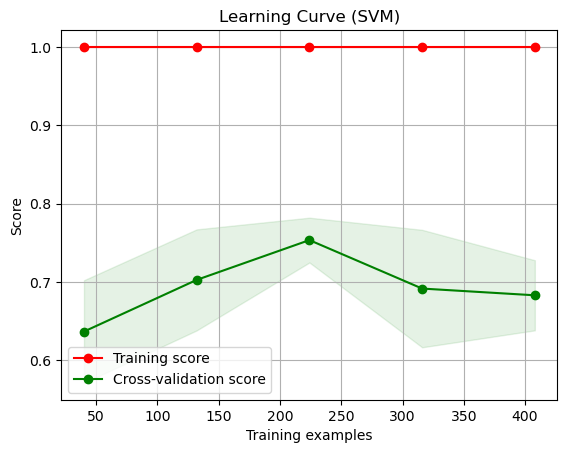

In [20]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for the best SVM model
plot_learning_curve(svm_grid_search.best_estimator_, "Learning Curve (SVM)", x_train_nc, y_train_nc, cv=StratifiedKFold(10))
plt.show()